<a href="https://colab.research.google.com/github/Ganesh-2250/NLP/blob/main/NLP_Assign2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Assignment 2

```
T Ganesh
24B2250
```



STEP-1

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from gensim import corpora
from sklearn.metrics import classification_report

# Download NLTK tokenizer (only once)
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

STEP-2


In [24]:

df = pd.read_csv("yelp_reviews_subset_2.csv")
df.head()


,Unnamed: 0,Text,Labels
0,0,My expectations for McDonalds are t rarely hig...,0
1,1,I've tried to give this McDonalds a chance but...,0
2,2,This McDonald's is so bad it's amazing. \n\nO...,0
3,3,We had the worst possible experience at the Ea...,0
4,4,They burned my fish and they burned it bad. O...,2


STEP-3

/tmp/ipython-input-2860964221.py:13: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(df['sentiment']).plot.bar(title="Sentiment distribution in df")


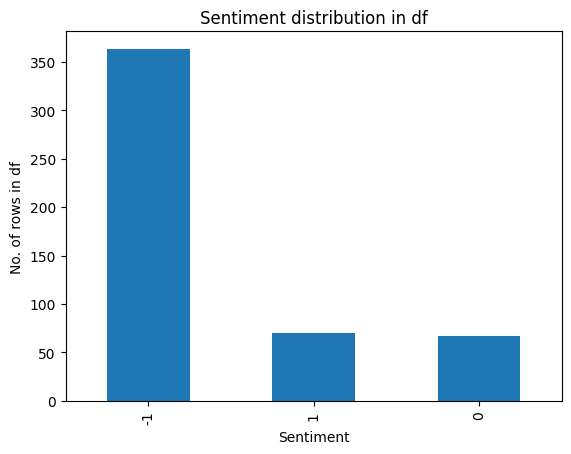

In [25]:
def map_sentiment(stars_received):
    if stars_received <= 2:
        return -1
    elif stars_received == 3:
        return 0
    else:
        return 1

df['sentiment'] = [map_sentiment(x) for x in df['Labels']]

plt.figure()
pd.value_counts(df['sentiment']).plot.bar(title="Sentiment distribution in df")
plt.xlabel("Sentiment")
plt.ylabel("No. of rows in df")
plt.show()


STEP 4

In [26]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [27]:
df['tokenized_text'] = [word_tokenize(str(text)) for text in df['Text']]

ps = PorterStemmer()
df['stemmed_tokens'] = [[ps.stem(word) for word in tokens] for tokens in df['tokenized_text']]

print(df[['Text', 'tokenized_text', 'stemmed_tokens']].head())


                                                Text  \
0  My expectations for McDonalds are t rarely hig...   
1  I've tried to give this McDonalds a chance but...   
2  This McDonald's is so bad it's amazing.  \n\nO...   
3  We had the worst possible experience at the Ea...   
4  They burned my fish and they burned it bad.  O...   

                                      tokenized_text  \
0  [My, expectations, for, McDonalds, are, t, rar...   
1  [I, 've, tried, to, give, this, McDonalds, a, ...   
2  [This, McDonald, 's, is, so, bad, it, 's, amaz...   
3  [We, had, the, worst, possible, experience, at...   
4  [They, burned, my, fish, and, they, burned, it...   

                                      stemmed_tokens  
0  [my, expect, for, mcdonald, are, t, rare, high...  
1  [i, 've, tri, to, give, thi, mcdonald, a, chan...  
2  [thi, mcdonald, 's, is, so, bad, it, 's, amaz,...  
3  [we, had, the, worst, possibl, experi, at, the...  
4  [they, burn, my, fish, and, they, burn, it, ba..

STEP 5

In [28]:
def split_train_test(df, test_size=0.3, shuffle_state=True):
    X_train, X_test, Y_train, Y_test = train_test_split(
        df[["Text", "Labels", "tokenized_text", "stemmed_tokens"]],
        df['sentiment'],
        shuffle=shuffle_state,
        test_size=test_size,
        random_state=15
    )

    print("Value counts for Train sentiments:")
    print(Y_train.value_counts())
    print("Value counts for Test sentiments:")
    print(Y_test.value_counts())

    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    Y_train = Y_train.reset_index(drop=True).to_frame()
    Y_test = Y_test.reset_index(drop=True).to_frame()

    return X_train, X_test, Y_train, Y_test

X_train, X_test, Y_train, Y_test = split_train_test(df)


Value counts for Train sentiments:
sentiment
-1    255
 1     49
 0     46
Name: count, dtype: int64
Value counts for Test sentiments:
sentiment
-1    108
 1     21
 0     21
Name: count, dtype: int64


STEP 6

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running:", device)


Device available for running: cuda


STEP 7

In [30]:
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return F.softmax(out, dim=1)


STEP 8

In [31]:
def make_dict(top_data_df_small, padding=True):
    if padding:
        print("Dictionary with padded token added")
        review_dict = corpora.Dictionary([['pad']])
        review_dict.add_documents(top_data_df_small['stemmed_tokens'])
    else:
        print("Dictionary without padding")
        review_dict = corpora.Dictionary(top_data_df_small['stemmed_tokens'])
    return review_dict

review_dict = make_dict(df, padding=False)


Dictionary without padding


STEP 9

In [32]:
VOCAB_SIZE = len(review_dict)
NUM_LABELS = 3

def make_bow_vector(review_dict, sentence):
    vec = torch.zeros(VOCAB_SIZE, dtype=torch.float64, device=device)
    for word in sentence:
        if word in review_dict.token2id:
            vec[review_dict.token2id[word]] += 1
    return vec.view(1, -1).float()

def make_target(label):
    if label == -1:
        return torch.tensor([0], dtype=torch.long, device=device)
    elif label == 0:
        return torch.tensor([1], dtype=torch.long, device=device)
    else:
        return torch.tensor([2], dtype=torch.long, device=device)


STEP 10

In [33]:
input_dim = VOCAB_SIZE
hidden_dim = 500
output_dim = 3
num_epochs = 100

ff_nn_bow_model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)
ff_nn_bow_model = ff_nn_bow_model.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(ff_nn_bow_model.parameters(), lr=1e-3)


STEP 11

In [34]:
ffnn_loss_file_name = 'ffnn_bow_class_big_loss_500_epoch_100_less_lr.csv'
f = open(ffnn_loss_file_name, 'w')
f.write('iter, loss\n')

for epoch in range(num_epochs):
    if (epoch + 1) % 25 == 0:
        print(f"Epoch completed: {epoch + 1}")
    train_loss = 0
    for index, row in X_train.iterrows():
        optimizer.zero_grad()
        bow_vec = make_bow_vector(review_dict, row['stemmed_tokens'])
        probs = ff_nn_bow_model(bow_vec)
        target = make_target(Y_train['sentiment'][index])
        loss = loss_function(probs, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    f.write(f"{epoch + 1},{train_loss / len(X_train)}\n")
f.close()


Epoch completed: 25
Epoch completed: 50
Epoch completed: 75
Epoch completed: 100


STEP 12

              precision    recall  f1-score   support

           0       0.72      1.00      0.84       108
           1       0.00      0.00      0.00        21
           2       0.00      0.00      0.00        21

    accuracy                           0.72       150
   macro avg       0.24      0.33      0.28       150
weighted avg       0.52      0.72      0.60       150



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


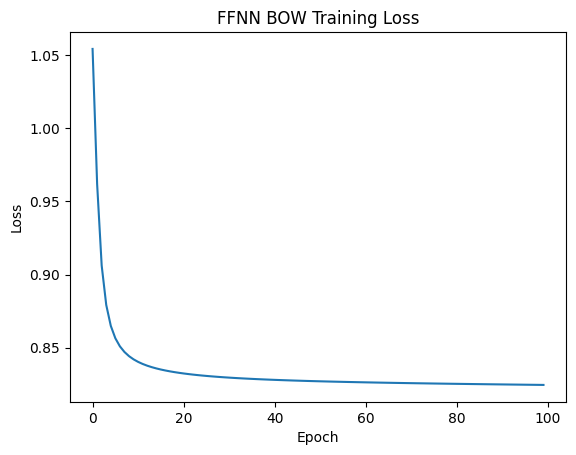

In [35]:
bow_ff_nn_predictions = []
original_labels_ff_bow = []

with torch.no_grad():
    for index, row in X_test.iterrows():
        bow_vec = make_bow_vector(review_dict, row['stemmed_tokens'])
        probs = ff_nn_bow_model(bow_vec)
        bow_ff_nn_predictions.append(torch.argmax(probs, dim=1).cpu().numpy()[0])
        original_labels_ff_bow.append(make_target(Y_test['sentiment'][index]).cpu().numpy()[0])

print(classification_report(original_labels_ff_bow, bow_ff_nn_predictions))

ffnn_loss_df = pd.read_csv(ffnn_loss_file_name)
ffnn_loss_df[' loss'].plot(title="FFNN BOW Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig("ffnn_bow_loss_500_padding_100_epochs_less_lr.jpg")
plt.show()


STEP 13

In [36]:
class FeedforwardNeuralNetModelDropout(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.3):
        super(FeedforwardNeuralNetModelDropout, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.fc3(out)
        return F.softmax(out, dim=1)

ff_nn_bow_model_dropout = FeedforwardNeuralNetModelDropout(input_dim, hidden_dim, output_dim, dropout_rate=0.3)
ff_nn_bow_model_dropout = ff_nn_bow_model_dropout.to(device)

loss_function_dropout = nn.CrossEntropyLoss()
optimizer_dropout = optim.SGD(ff_nn_bow_model_dropout.parameters(), lr=1e-3)

ffnn_loss_file_name_dropout = 'ffnn_bow_class_big_loss_500_epoch_100_less_lr_dropout.csv'
f_dropout = open(ffnn_loss_file_name_dropout, 'w')
f_dropout.write('iter, loss\n')

for epoch in range(num_epochs):
    if (epoch + 1) % 25 == 0:
        print(f"Epoch completed: {epoch + 1}")
    train_loss_dropout = 0
    for index, row in X_train.iterrows():
        optimizer_dropout.zero_grad()
        bow_vec = make_bow_vector(review_dict, row['stemmed_tokens'])
        probs = ff_nn_bow_model_dropout(bow_vec)
        target = make_target(Y_train['sentiment'][index])
        loss = loss_function_dropout(probs, target)
        train_loss_dropout += loss.item()
        loss.backward()
        optimizer_dropout.step()
    f_dropout.write(f"{epoch + 1},{train_loss_dropout / len(X_train)}\n")
f_dropout.close()


Epoch completed: 25
Epoch completed: 50
Epoch completed: 75
Epoch completed: 100


STEP 14

Classification Report with Dropout:
              precision    recall  f1-score   support

           0       0.72      1.00      0.84       108
           1       0.00      0.00      0.00        21
           2       0.00      0.00      0.00        21

    accuracy                           0.72       150
   macro avg       0.24      0.33      0.28       150
weighted avg       0.52      0.72      0.60       150



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


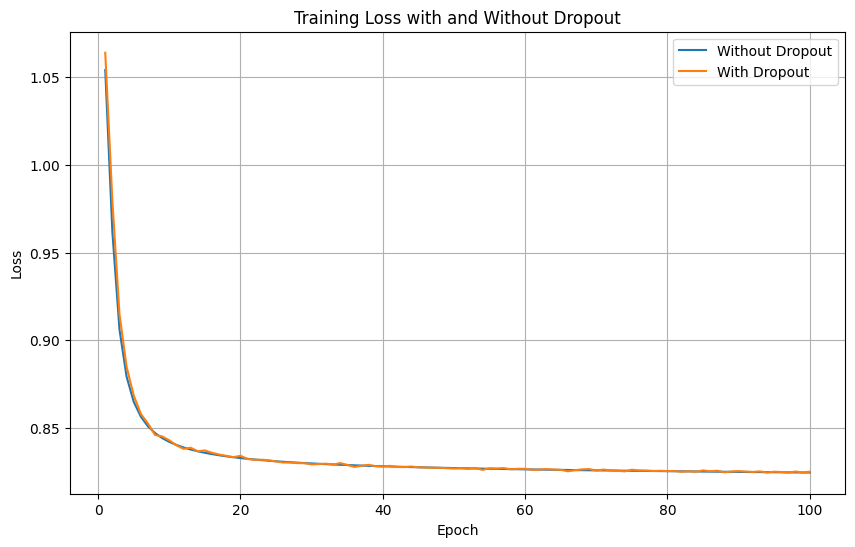

In [37]:
bow_ff_nn_predictions_dropout = []
original_labels_ff_bow_dropout = []

ff_nn_bow_model_dropout.eval()
with torch.no_grad():
    for index, row in X_test.iterrows():
        bow_vec = make_bow_vector(review_dict, row['stemmed_tokens'])
        probs = ff_nn_bow_model_dropout(bow_vec)
        bow_ff_nn_predictions_dropout.append(torch.argmax(probs, dim=1).cpu().numpy()[0])
        original_labels_ff_bow_dropout.append(make_target(Y_test['sentiment'][index]).cpu().numpy()[0])

print("Classification Report with Dropout:")
print(classification_report(original_labels_ff_bow_dropout, bow_ff_nn_predictions_dropout))

ffnn_loss_df = pd.read_csv(ffnn_loss_file_name)
ffnn_loss_df_dropout = pd.read_csv(ffnn_loss_file_name_dropout)

plt.figure(figsize=(10, 6))
plt.plot(ffnn_loss_df['iter'], ffnn_loss_df[' loss'], label='Without Dropout')
plt.plot(ffnn_loss_df_dropout['iter'], ffnn_loss_df_dropout[' loss'], label='With Dropout')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss with and Without Dropout')
plt.legend()
plt.grid(True)
plt.savefig("ffnn_bow_loss_comparison_dropout.jpg")
plt.show()
